### fusion

In [2]:
import os
import sys 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import *
#scipy.signal.convolve2d

abs_path=os.path.abspath(os.curdir)
cvlib_path=abs_path+"/../cvlib/"
sys.path.append(cvlib_path)
from convs import *
from sobel import *

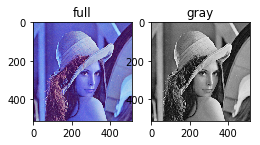

In [3]:
originImage = cv2.imread("../lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("../lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 3, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)
#plt.subplot(1, 3, 3)
#plt.title("gray32x32")
#plt.gray()
#plt.imshow(grayImage32x32)

#### Gaussian pyramid
1. sigmas
    
    1. 高斯金字塔有O组金字塔,每组内部是分辨率相同但是filter尺度不同的图像.
    O组的最大如下(向下取整):
    $$O=log_2min(X,Y)-2$$
    
    2. 单一组内金字塔的层数S(Lowe建议s为3)
    $$S=s+3$$
    
    3, 但一组内每层的sigma,sigma0是基层的.
    $$\sigma _0,k\sigma _0,k^2\sigma _0,k^3\sigma _0,k^4\sigma _0$$
    
    4. k的确定,s为小s.
    $$k=2^{\frac{1}{s}}$$
    $$\sigma=k^r\sigma_0;  r\in[0,...,s+2]$$
    
    5. 每组外,靠金字塔上的一组是本组的down size.
    
    6. 第1组的sigma
    $$\sigma=2k^r\sigma_0;  r\in[0,...,s+2]$$
    
    
> 综合:
    $$\sigma(o,r)=\sigma_02^{o+\frac{r}{s}}$$
    
2. gaussian filter

3. downsize



In [57]:
def downsize(src,stride=2):
    w,h=src.shape
    dest=np.zeros((int(w/2),int(h/2)),np.float32)
    for i in range(int(w/2)):
        for j in range(int(h/2)):
            dest[i,j]=src[i*2,j*2]
    return dest
def upsize(src,stride=2):
    w,h=src.shape
    dest=np.zeros((int(w*2),int(h*2)),np.float32)
    for i in range(int(w)):
        for j in range(int(h)):
            dest[i*stride,j*stride]=src[i,j]
            dest[i*stride+1,j*stride+1]=0
    return dest
    

In [71]:
def Gaussian_pyramid(src,sigma,layer,group):
    #gf_img=Gaussian_filter(src=src,sigma=1.3, k_h=3,k_w=3)
    # step1 calc sigmas
    s=layer
    sigmas=np.zeros((s+3,1),np.float32)
    S=s+3
    k=np.power(2,1.0/s)
    sigmas[0]=sigma
    for layeridx in range(1,s+3):
        sig_prev=np.power(k,layeridx-1)*sigmas[0]
        sig_cur=sig_prev*k
        sig_guassian=np.sqrt(sig_cur**2-sig_prev**2)
        sigmas[layeridx]=sig_guassian
    print("k:%s",k)
    #return sigmas
    print(sigmas)
    dest={}
    for o in range(group):
        for i in range(s+3):
            if o==0 and i==0:
                temp=src.copy()
                dest[(o,i)]=src
            elif i==0:
                temp=dest[(o-1,s)].copy()
                print("o:%s,i:%s,shape:%s"%(o,i,temp.shape))
                dest[(o,i)]=downsize(temp,2)
            else:
                temp=dest[(o,i-1)].copy()
                dest[(o,i)]=Gaussian_filter(temp,sigmas[i],7,7)
     
    return dest,sigmas

In [72]:
dict_img,sigmas=Gaussian_pyramid(grayImage,1.5,3,3)


k:%s 1.2599210498948732
[[1.5      ]
 [1.1496314]
 [1.4484448]
 [1.824926 ]
 [2.2992628]
 [2.8968897]]
o:1,i:0,shape:(530, 530)
o:2,i:0,shape:(283, 283)


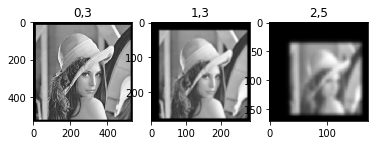

In [60]:
plt.subplot(1, 3, 1)
plt.title("0,3")
plt.imshow(dict_img[(0,3)])
plt.subplot(1, 3, 2)
plt.title("1,3")
plt.imshow(dict_img[(1,3)])
plt.subplot(1, 3, 3)
plt.title("2,5")
plt.imshow(dict_img[(2,5)])

In [61]:
A={}
A[(0,0)]=(1,2)
A[(0,1)]=(3,4)
A

{(0, 0): (1, 2), (0, 1): (3, 4)}

### Laplacian pyramid

In [67]:
def Laplacian_pyramid(gDict,group,layer,sigmas):
    lap_dest={}
    for o in range(group):
        for s in range(layer+3-1): # 少一层 
            # 高斯当前层
            gcurLayer=gDict[(o,s)]
            # 高斯上一层
            gUpperLayer=gDict[(o+1,s)]
            gUpSizeUpperLayer=upsize(gUpperLayer,2)
            gUpSizeUpperLayerGuass=Gaussian_filter(gUpSizeUpperLayer,sigmas[s],7,7)
            lap_dest[(o,s)]=gcurLayer-gUpSizeUpperLayerGuass
    return lap_dest

In [68]:
lap_img=Laplacian_pyramid(dict_img,3,3,sigmas)

ValueError: operands could not be broadcast together with shapes (512,512) (1042,1042) 